# Simple interaction models and the Judgement of Princeton

In [1]:
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm, arviz as az
from scipy import stats
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [4]:
wines = pd.read_csv('data/Wines2012.csv', sep = ';')
wines.head(10)

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0
5,Jean-M Cardebat,white,F1,13.0,1,0
6,Jean-M Cardebat,white,G1,15.0,1,0
7,Jean-M Cardebat,white,H1,11.0,0,0
8,Jean-M Cardebat,white,I1,9.0,1,0
9,Jean-M Cardebat,white,J1,12.0,0,0


## Preprocessing

In [5]:
wines[['wine']] = OrdinalEncoder(dtype=np.int64).fit_transform(wines[['wine']])
wines[['judge']] = OrdinalEncoder(dtype=np.int64).fit_transform(wines[['judge']])
wines['flight'] = 1 - OrdinalEncoder(dtype=np.int64).fit_transform(wines[['flight']])
wines[['score']] = StandardScaler().fit_transform(wines[['score']])
wines

,judge,flight,wine,score,wine.amer,judge.amer
0,3,0,0,-1.581002,1,0
1,3,0,2,-0.451715,1,0
2,3,0,4,-0.075286,0,0
3,3,0,6,0.301143,0,0
4,3,0,8,-2.333860,1,0
...,...,...,...,...,...,...
175,1,1,11,-0.828144,1,1
176,1,1,13,0.301143,0,1
177,1,1,15,0.677572,1,1
178,1,1,17,-2.710289,1,1


## Model 1: simple effects of wine and judge

Let's start by examining the effects of the wine and the judge.

$$ \begin{align*}
    y_i &\sim \mathrm{Normal}(\mu_i, \sigma) \\
    \mu_i &\sim \alpha + \beta_{W[j]} + \beta_{J[k]} \\
    \beta_{W[j]} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{J[k]} &\sim \mathrm{Normal}(0, 0.5) \\
    \alpha &\sim \mathrm{Normal}(0, 0.2) \\
    \sigma &\sim \mathrm{Exponential}(1) \end{align*} $$
    
The brackets on the parameters indicate indexing; so, we really have a vector of $\beta_W$s, and we select out the relevant one for each wine.

In [10]:
with pm.Model() as wj_model:
    # Priors for parameters
    aW = pm.Normal('aW', 0, 0.5, shape = 20)
    aJ = pm.Normal('aJ', 0, 0.5, shape = 9)
    alpha = pm.Normal('alpha', 0, 0.2)
    sigma = pm.Exponential('sigma', 1)
    
    # Model equation
    mu = alpha + aW[wines['wine'].values] + aJ[wines['judge'].values] # use .values here to avoid annoying theano warnings
    
    # Observation model
    score = pm.Normal('score', mu = mu, sigma = sigma, observed = wines['score'])
    
    # Sampling
    wj_trace = pm.sample(2000, target_accept = 0.95)
    wj_sumtab = az.summary(wj_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, aJ, aW]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


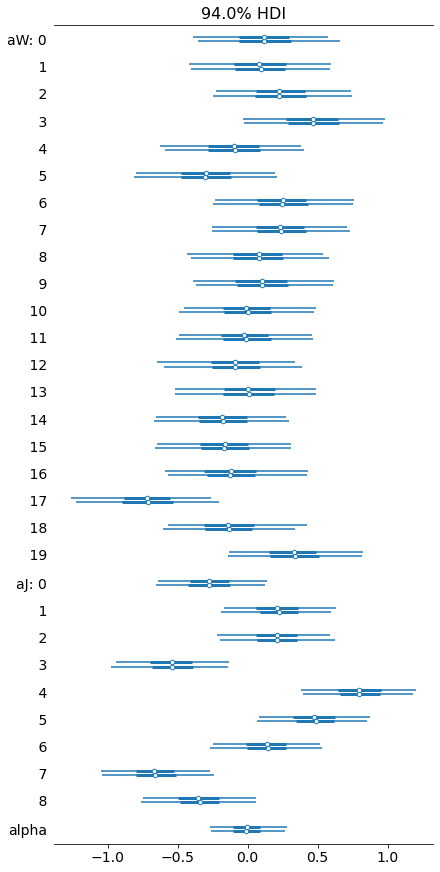

In [11]:
with wj_model:
    az.plot_forest(wj_trace, var_names = wj_trace.varnames.remove('sigma'))

There isn't a lot of variation between the wines; only one wine has its posterior interval completely away from 0, and a few more (e.g. wines 3, 5, 19) are close. There is more variation among judges, with several who consistently rate wines higher or lower than average. Judges rate by their own "internal scales", so this generally makes sense.

## Simple model: color/judge/region effects

There is a slight distinction between two approaches we can take to writing down the model. We can use indicator variables:

$$ \begin{align*} y_i &\sim \mathrm{Normal}(\mu_i, \sigma) \\
    \mu_i &\sim \alpha + \beta_{C} C + \beta_{J} J + \beta_{R} R \\
    \beta_{C} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{J} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{R} &\sim \mathrm{Normal}(0, 0.5) \\
    \alpha &\sim \mathrm{Normal}(0, 0.2) \\
    \sigma &\sim \mathrm{Exponential}(1) \end{align*} $$
where $C, J, R$ are indicators: 
* $C = 0$ if the wine is white, $C = 1$ if the wine is red
* $J = 0$ if the judge is French, $J = 1$ if the judge is American
* $R = 0$ if the wine is French, $R = 1$ if the wine is American

In [12]:
# Indicator variable version
with pm.Model() as indicator_model:
    # Priors
    bR = pm.Normal('bR', 0, 0.5)
    bJ = pm.Normal('bJ', 0, 0.5)
    bC = pm.Normal('bC', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    
    # Model equation
    mu = alpha + bC * wines['flight'] + bJ * wines['judge.amer'] + bR * wines['wine.amer']
    
    # Observation model
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    # Sampling
    indicator_trace = pm.sample(1000, target_accept = 0.9)
    indicator_sumtab = az.summary(indicator_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, bC, bJ, bR]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [13]:
indicator_sumtab

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bR,-0.176,0.135,-0.422,0.085,0.003,0.002,1901.0,1500.0,1.0
bJ,0.227,0.139,-0.041,0.482,0.003,0.002,1747.0,1556.0,1.0
bC,-0.008,0.138,-0.260,0.248,0.003,0.003,1788.0,1437.0,1.0
alpha,-0.015,0.127,-0.252,0.217,0.003,0.003,1337.0,1148.0,1.0
sigma,1.002,0.055,0.904,1.106,0.001,0.001,2100.0,1560.0,1.0


/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

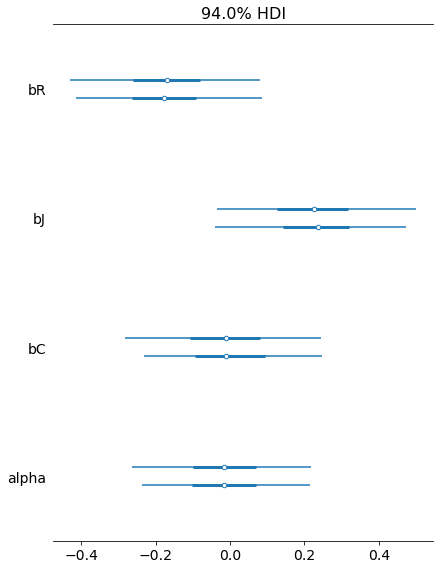

In [14]:
az.plot_forest(indicator_trace, var_names = ['bR', 'bJ', 'bC', 'alpha'])

Two strong effects: region and judge. What if we include interactions?

In [15]:
with pm.Model() as interaction:
    # Priors
    bR = pm.Normal('bR', 0, 0.5)
    bJ = pm.Normal('bJ', 0, 0.5)
    bC = pm.Normal('bC', 0, 0.5)
    # Tighter regularization on interaction effects
    bCJ = pm.Normal('bCJ', 0, 0.25)
    bJR = pm.Normal('bJR', 0, 0.25)
    bRC = pm.Normal('bRC', 0, 0.25)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    
    # Model equation
    mu = alpha + bC * wines['flight'] + bJ * wines['judge.amer'] + bR * wines['wine.amer'] + \
        bJR * wines['judge.amer'] * wines['wine.amer'] + bCJ * wines['judge.amer'] * wines['flight'] + \
        bRC * wines['flight'] * wines['wine.amer']
    
    # Observation model
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    # Sampling
    int_trace = pm.sample(1000, target_accept = 0.9)
    int_sumtab = az.summary(int_trace, var_names = ['alpha', 'bR', 'bJ', 'bC', 'bCJ', 'bJR', 'bRC'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, bRC, bJR, bCJ, bC, bJ, bR]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [16]:
int_sumtab

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.039,0.133,-0.280,0.209,0.004,0.003,1184.0,1410.0,1.0
bR,-0.078,0.175,-0.414,0.238,0.005,0.004,1410.0,1455.0,1.0
bJ,0.208,0.176,-0.108,0.560,0.006,0.004,997.0,1199.0,1.0
bC,0.085,0.188,-0.285,0.415,0.005,0.005,1302.0,1089.0,1.0
bCJ,0.044,0.186,-0.315,0.361,0.005,0.004,1479.0,1383.0,1.0
bJR,-0.029,0.185,-0.387,0.302,0.005,0.004,1531.0,1485.0,1.0
bRC,-0.223,0.181,-0.574,0.110,0.005,0.004,1512.0,1473.0,1.0


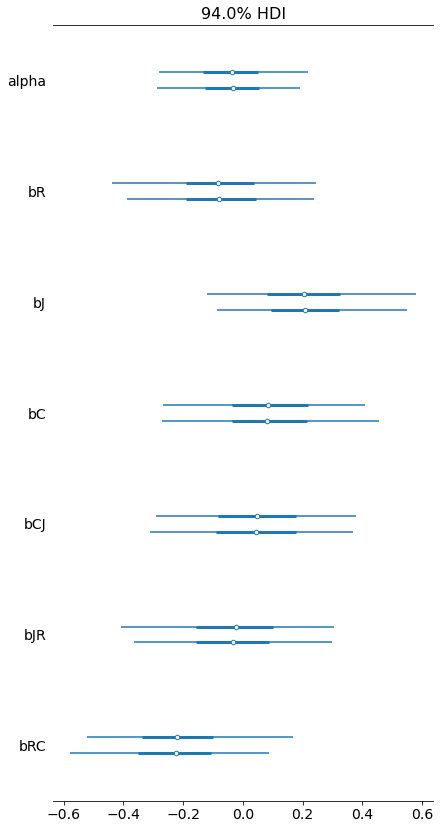

In [17]:
with interaction:
    az.plot_forest(int_trace, var_names = ['alpha', 'bR', 'bJ', 'bC', 'bCJ', 'bJR', 'bRC'])

## Visualizing the predictions

Interpreting the parameters, especially the interaction parameters, can be a bit tricky. To clarify this, let's extract samples from the trace to evaluate our predicted scores for each of the combinations of predictors. We can do this by simply plugging the sampled values from the trace into the model equation.

In [19]:
RAA = int_trace['bR'] + int_trace['bJ'] + int_trace['bC'] + \
      int_trace['bCJ'] + int_trace['bJR'] + int_trace['bRC'] + int_trace['alpha']
WAA = int_trace['bJ'] + int_trace['bR'] + int_trace['bC'] + int_trace['bRC'] + int_trace['alpha']
RFA = int_trace['bC'] + int_trace['bR'] + int_trace['bRC'] + int_trace['alpha']
WFA = int_trace['bR'] + int_trace['alpha']
RAF = int_trace['bC'] + int_trace['bJ'] + int_trace['bCJ'] + int_trace['alpha']
WAF = int_trace['bJ'] + int_trace['alpha']
RFF = int_trace['bC'] + int_trace['alpha']
WFF = int_trace['alpha']

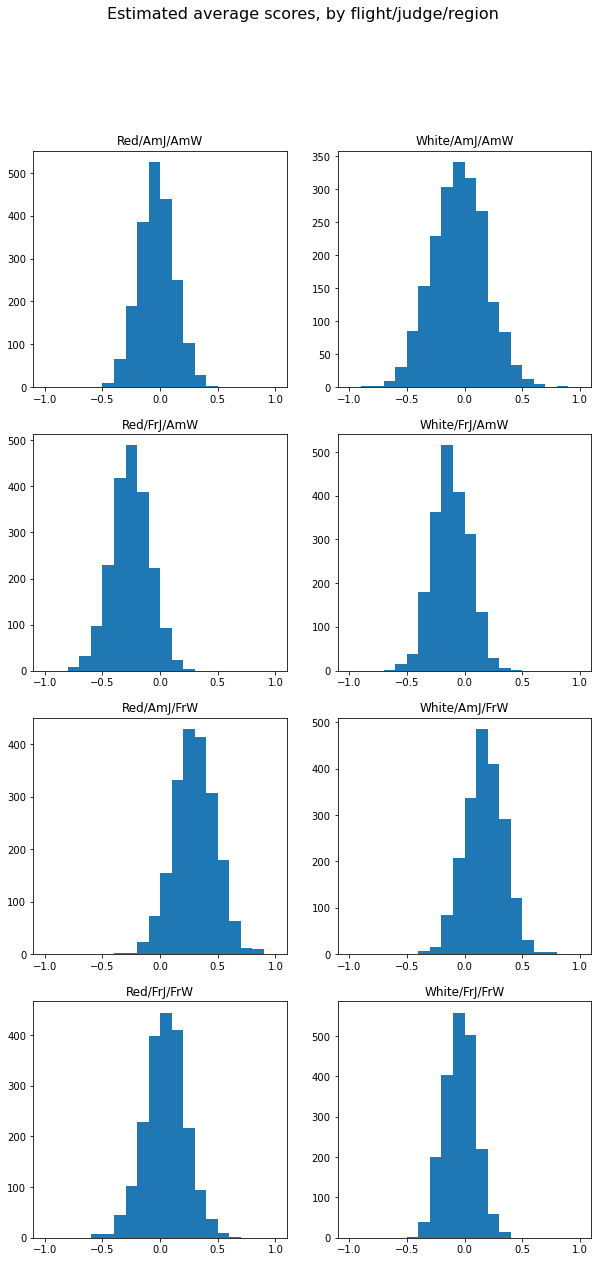

In [20]:
fig, axs = plt.subplots(4,2, figsize = (10, 20))
fig.suptitle('Estimated average scores, by flight/judge/region', size = 16)
axs[0,0].hist(RAA, bins = np.arange(-1, 1.1, 0.1))
axs[0,0].set_title('Red/AmJ/AmW')
axs[1,0].hist(RFA, bins = np.arange(-1, 1.1, 0.1))
axs[1,0].set_title('Red/FrJ/AmW')
axs[2,0].hist(RAF, bins = np.arange(-1, 1.1, 0.1))
axs[2,0].set_title('Red/AmJ/FrW')
axs[3,0].hist(RFF, bins = np.arange(-1, 1.1, 0.1))
axs[3,0].set_title('Red/FrJ/FrW')
axs[0,1].hist(WAA, bins = np.arange(-1, 1.1, 0.1))
axs[0,1].set_title('White/AmJ/AmW')
axs[1,1].hist(WFA, bins = np.arange(-1, 1.1, 0.1))
axs[1,1].set_title('White/FrJ/AmW')
axs[2,1].hist(WAF, bins = np.arange(-1, 1.1, 0.1))
axs[2,1].set_title('White/AmJ/FrW')
axs[3,1].hist(WFF, bins = np.arange(-1, 1.1, 0.1))
axs[3,1].set_title('White/FrJ/FrW')
plt.show()

This clarifies the region/color interaction, which was the only clearly nonzero interaction from the parameter table. Red French wines were rated higher than average by American judges (although only about average by French judges) while red American wines were rated relatively poorly by the French judges. So, being red and American together appears to carry a bit of a disadvantage -- although how this manifests is dependent on the judge.

### Full interaction model

In [21]:
with pm.Model() as interaction:
    b = pm.Normal('b', 0, 0.5, shape = (2, 2, 2))
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    mu = b[wines['flight'], wines['judge.amer'], wines['wine.amer']]
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    fullint_trace = pm.sample(1000, target_accept = 0.9)
    fullint_sumtab = az.summary(fullint_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [22]:
fullint_sumtab

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b[0,0,0]",-0.305,0.215,-0.723,0.093,0.003,0.003,4360.0,1388.0,1.00
"b[0,0,1]",0.035,0.186,-0.346,0.362,0.003,0.004,4250.0,1624.0,1.01
"b[0,1,0]",0.162,0.206,-0.213,0.555,0.003,0.004,3645.0,1513.0,1.00
"b[0,1,1]",0.038,0.168,-0.263,0.372,0.003,0.004,3572.0,1278.0,1.00
"b[1,0,0]",0.210,0.216,-0.185,0.607,0.004,0.004,3403.0,1433.0,1.00
"b[1,0,1]",-0.357,0.186,-0.698,-0.005,0.003,0.003,3363.0,1556.0,1.00
"b[1,1,0]",0.266,0.206,-0.109,0.661,0.003,0.003,3552.0,1449.0,1.00
"b[1,1,1]",-0.016,0.169,-0.351,0.286,0.003,0.004,3206.0,1518.0,1.00
alpha,0.003,0.204,-0.387,0.380,0.003,0.005,3973.0,1403.0,1.00
sigma,0.993,0.052,0.901,1.093,0.001,0.001,2882.0,1449.0,1.00


In [ ]:
fullint_trace['b'][:,0,0,0]

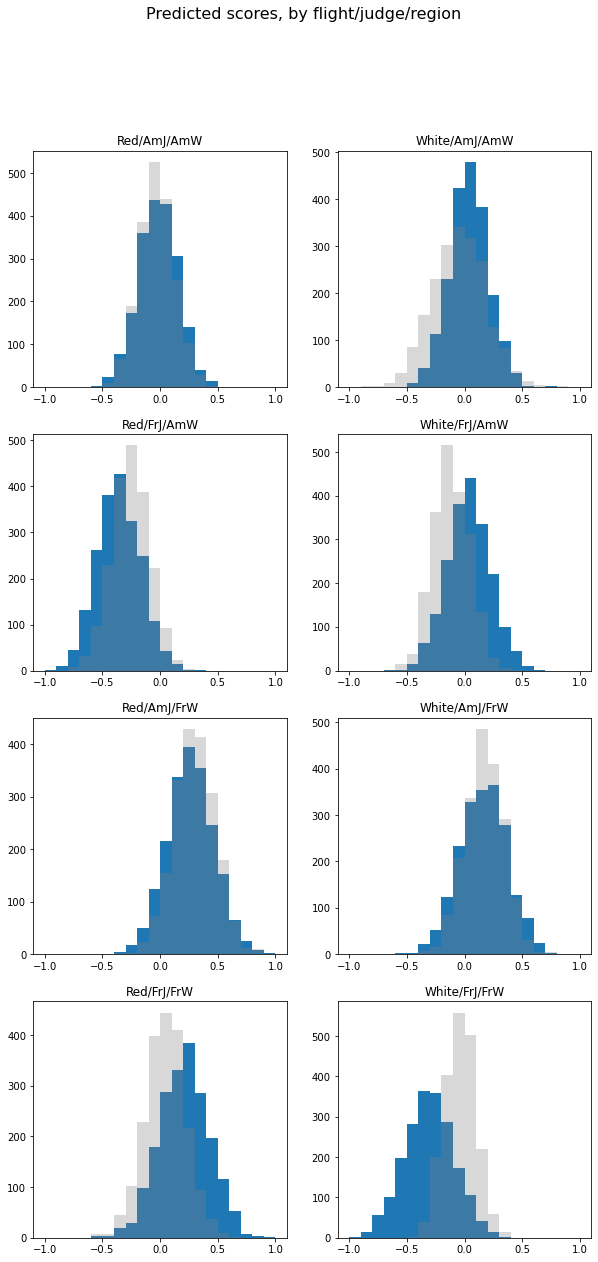

In [23]:
fig, axs = plt.subplots(4,2, figsize = (10, 20))
fig.suptitle('Predicted scores, by flight/judge/region', size = 16)
axs[0,0].hist(fullint_trace['b'][:,1,1,1], bins = np.arange(-1, 1.1, 0.1))
axs[0,0].set_title('Red/AmJ/AmW')
axs[1,0].hist(fullint_trace['b'][:,1,0,1], bins = np.arange(-1, 1.1, 0.1))
axs[1,0].set_title('Red/FrJ/AmW')
axs[2,0].hist(fullint_trace['b'][:,1,1,0], bins = np.arange(-1, 1.1, 0.1))
axs[2,0].set_title('Red/AmJ/FrW')
axs[3,0].hist(fullint_trace['b'][:,1,0,0], bins = np.arange(-1, 1.1, 0.1))
axs[3,0].set_title('Red/FrJ/FrW')
axs[0,1].hist(fullint_trace['b'][:,0,1,1], bins = np.arange(-1, 1.1, 0.1))
axs[0,1].set_title('White/AmJ/AmW')
axs[1,1].hist(fullint_trace['b'][:,0,0,1], bins = np.arange(-1, 1.1, 0.1))
axs[1,1].set_title('White/FrJ/AmW')
axs[2,1].hist(fullint_trace['b'][:,0,1,0], bins = np.arange(-1, 1.1, 0.1))
axs[2,1].set_title('White/AmJ/FrW')
axs[3,1].hist(fullint_trace['b'][:,0,0,0], bins = np.arange(-1, 1.1, 0.1))
axs[3,1].set_title('White/FrJ/FrW')

# Predictions from the previous model
axs[0,0].hist(RAA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[1,0].hist(RFA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[2,0].hist(RAF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[3,0].hist(RFF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[0,1].hist(WAA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[1,1].hist(WFA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[2,1].hist(WAF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[3,1].hist(WFF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)

plt.show()

The biggest difference is that the White/French/French predicted score is lower in this model. Why? The previous model is artificially "centered" on White/French/French. 
In the previous model, White/French/French corresponds to all the indicator variables being zero, so we just have
$$ \hat y = \alpha $$
and since our outcomes are standardized, we should generally have $\alpha = 0$. This has, in a way, positioned White/French/French artificially as a "default", with all wines measured relative to it.

In this model, every combination of traits gets its own parameter, and so they can vary freely.